In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,GenericMask
from detectron2.data import MetadataCatalog, DatasetCatalog

/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

### dataset resgisteration

In [3]:
# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
# balloon_metadata = MetadataCatalog.get("balloon_train")

### train start

In [4]:
from detectron2.engine import DefaultTrainer 
from detectron2.data import transforms as T
from detectron2.data import DatasetMapper, build_detection_train_loader

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

class MyTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        transform_list = [T.RandomApply(T.RandomFlip(prob=0.5, horizontal=True, vertical=False), prob=1),
                                   T.Resize((512, 512)),
                                   T.RandomCrop("absolute",(256, 256))
                          ]
        mapper = DatasetMapper(cfg, is_train=True, augmentations=transform_list)
        return build_detection_train_loader(cfg, mapper=mapper)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/06 08:44:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/06 08:44:14 d2.engine.train_loop]: Starting training from iteration 0


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:19 d2.utils.events]:  eta: 0:00:50  iter: 19  total_loss: 2.307  loss_cls: 0.8464  loss_box_reg: 0.5704  loss_mask: 0.6819  loss_rpn_cls: 0.1183  loss_rpn_loc: 0.01201  time: 0.1863  data_time: 0.0562  lr: 1.6068e-05  max_mem: 1085M
[10/06 08:44:22 d2.utils.events]:  eta: 0:00:46  iter: 39  total_loss: 1.893  loss_cls: 0.6017  loss_box_reg: 0.498  loss_mask: 0.6349  loss_rpn_cls: 0.07519  loss_rpn_loc: 0.008223  time: 0.1873  data_time: 0.0255  lr: 3.2718e-05  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:26 d2.utils.events]:  eta: 0:00:42  iter: 59  total_loss: 1.755  loss_cls: 0.4393  loss_box_reg: 0.5589  loss_mask: 0.5325  loss_rpn_cls: 0.1184  loss_rpn_loc: 0.01418  time: 0.1880  data_time: 0.0201  lr: 4.9367e-05  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:30 d2.utils.events]:  eta: 0:00:39  iter: 79  total_loss: 1.58  loss_cls: 0.368  loss_box_reg: 0.6617  loss_mask: 0.4304  loss_rpn_cls: 0.0611  loss_rpn_loc: 0.01287  time: 0.1896  data_time: 0.0269  lr: 6.6017e-05  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:34 d2.utils.events]:  eta: 0:00:35  iter: 99  total_loss: 1.388  loss_cls: 0.3112  loss_box_reg: 0.5592  loss_mask: 0.3297  loss_rpn_cls: 0.03949  loss_rpn_loc: 0.004708  time: 0.1903  data_time: 0.0245  lr: 8.2668e-05  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:38 d2.utils.events]:  eta: 0:00:31  iter: 119  total_loss: 1.225  loss_cls: 0.2365  loss_box_reg: 0.582  loss_mask: 0.2788  loss_rpn_cls: 0.07084  loss_rpn_loc: 0.008185  time: 0.1894  data_time: 0.0135  lr: 9.9318e-05  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:42 d2.utils.events]:  eta: 0:00:28  iter: 139  total_loss: 1.236  loss_cls: 0.2563  loss_box_reg: 0.5891  loss_mask: 0.2566  loss_rpn_cls: 0.09375  loss_rpn_loc: 0.01179  time: 0.1887  data_time: 0.0177  lr: 0.00011597  max_mem: 1092M
[10/06 08:44:45 d2.utils.events]:  eta: 0:00:24  iter: 159  total_loss: 1.277  loss_cls: 0.2324  loss_box_reg: 0.6199  loss_mask: 0.2161  loss_rpn_cls: 0.05311  loss_rpn_loc: 0.0152  time: 0.1889  data_time: 0.0226  lr: 0.00013262  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:49 d2.utils.events]:  eta: 0:00:21  iter: 179  total_loss: 0.8489  loss_cls: 0.1564  loss_box_reg: 0.4503  loss_mask: 0.1514  loss_rpn_cls: 0.05591  loss_rpn_loc: 0.007532  time: 0.1887  data_time: 0.0197  lr: 0.00014927  max_mem: 1092M
[10/06 08:44:53 d2.utils.events]:  eta: 0:00:17  iter: 199  total_loss: 0.7087  loss_cls: 0.1147  loss_box_reg: 0.4103  loss_mask: 0.1229  loss_rpn_cls: 0.03503  loss_rpn_loc: 0.008618  time: 0.1881  data_time: 0.0177  lr: 0.00016592  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:44:57 d2.utils.events]:  eta: 0:00:14  iter: 219  total_loss: 0.7399  loss_cls: 0.1407  loss_box_reg: 0.3757  loss_mask: 0.1312  loss_rpn_cls: 0.04681  loss_rpn_loc: 0.008675  time: 0.1891  data_time: 0.0282  lr: 0.00018257  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:45:01 d2.utils.events]:  eta: 0:00:10  iter: 239  total_loss: 0.8091  loss_cls: 0.1564  loss_box_reg: 0.3146  loss_mask: 0.1556  loss_rpn_cls: 0.06187  loss_rpn_loc: 0.02016  time: 0.1894  data_time: 0.0244  lr: 0.00019922  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:45:05 d2.utils.events]:  eta: 0:00:07  iter: 259  total_loss: 0.5505  loss_cls: 0.09561  loss_box_reg: 0.2133  loss_mask: 0.174  loss_rpn_cls: 0.03655  loss_rpn_loc: 0.009547  time: 0.1894  data_time: 0.0224  lr: 0.00021587  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:45:08 d2.utils.events]:  eta: 0:00:03  iter: 279  total_loss: 0.4366  loss_cls: 0.0796  loss_box_reg: 0.2429  loss_mask: 0.0783  loss_rpn_cls: 0.02103  loss_rpn_loc: 0.007518  time: 0.1896  data_time: 0.0248  lr: 0.00023252  max_mem: 1092M


/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/fvcore/transforms/transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


[10/06 08:45:14 d2.utils.events]:  eta: 0:00:00  iter: 299  total_loss: 0.4912  loss_cls: 0.1091  loss_box_reg: 0.1891  loss_mask: 0.09753  loss_rpn_cls: 0.03561  loss_rpn_loc: 0.01439  time: 0.1898  data_time: 0.0190  lr: 0.00024917  max_mem: 1092M
[10/06 08:45:14 d2.engine.hooks]: Overall training speed: 298 iterations in 0:00:56 (0.1898 s / it)
[10/06 08:45:14 d2.engine.hooks]: Total training time: 0:00:58 (0:00:01 on hooks)


In [18]:
import cv2

image = cv2.imread("../images/000000408774.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread("../images/mask/000000408774.png")


image2 = cv2.imread("../images/000000158945.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

mask2 = cv2.imread("../images/mask/000000158945.png")

In [19]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
    T.RandomCrop("absolute", (250, 250))
])  # type: T.Augmentation

# Define the augmentation input ("image" required, others optional):
input = T.AugInput(image,sem_seg=mask)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = input.image  # new image
sem_seg_transformed = input.sem_seg  # new semantic segmentation

# For any extra data that needs to be augmented together, use transform, e.g.:
image2_transformed = transform.apply_image(image2)
mask2_transformed = transform.apply_segmentation(mask2)

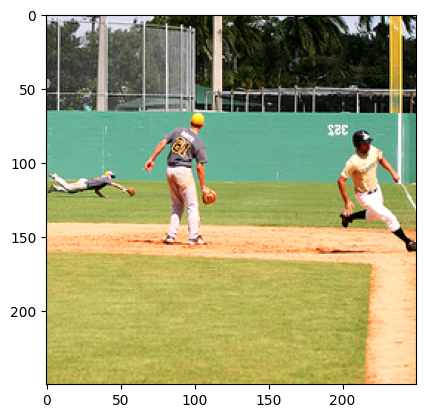

In [16]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

# plt.imshow(transformed_image)
plt.imshow(image_transformed)
plt.show()

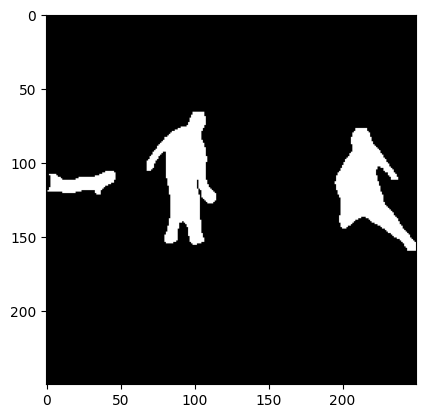

In [17]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

# plt.imshow(transformed_image)
plt.imshow(sem_seg_transformed)
plt.show()

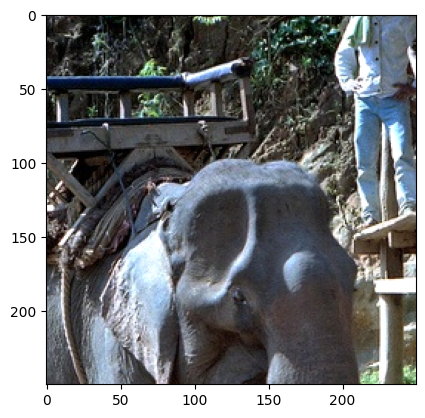

In [20]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

# plt.imshow(transformed_image)
plt.imshow(image2_transformed)
plt.show()

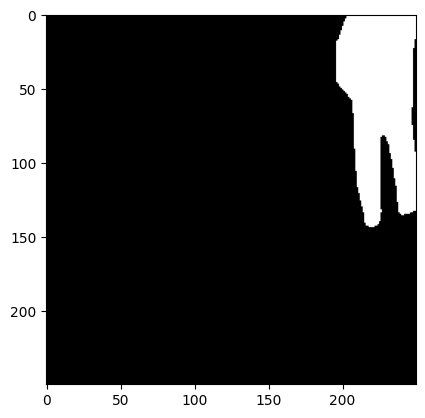

In [21]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

# plt.imshow(transformed_image)
plt.imshow(mask2_transformed)
plt.show()
